In [3]:
!pip3 install flair


     |████████████████████████████████| 319 kB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 753 kB/s  eta 0:00:01
     |████████████████████████████████| 64 kB 2.7 MB/s  eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 965 kB 26.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 50.9 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 4.9 MB/s  eta 0:00:01
     |████████████████████████████████| 24.2 MB 210 kB/s  eta 0:00:01    |██████████▌                     | 7.9 MB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 19.7 MB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 5.5 kB/s  eta 0:00:01     |███████████████████             | 491.2 MB 26.2 MB/s eta 0:00:13     |██████████████████████████████▎ | 786.7 M

  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-py3-none-any.whl size=14376 sha256=c78ca1719526a80d979bb4d2b4cf825841c4f587ff7cf16d45477674fe5cec74
  Stored in directory: /home/ragou/.cache/pip/wheels/92/82/8c/54ef8d8770fd1a80938197e55d3ccd26eccd117f44c58f601b
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=086fbdb1dbf4fb0071614d50787769735f18d91b28929284085eab49b6965276
  Stored in directory: /home/ragou/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-py3-none-any.whl size=13461 sha256=3ce90b8621a4c1f9a97c0da7ef9e45b3d0ffcef890d13cbb93706dc950c721f4
  Stored in directory: /home/ragou/.cache/pip/wheels/ed/88/e3/da3d4d73cb91d659488cfa25913b84bbc26febec99d257bce9
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116677 sha256=4479507b4a7a77eaf7b7ad68b72d00e711f22cf19709726273f721312c8b9e54
  Stored in directory: /home/rago

In [ ]:
!pip3 install tensorflow_hub

In [2]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [137]:
import tokenization # tokenization.py
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import nltk
import transformers
import re
import matplotlib.pyplot as plt

In [140]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
    # lowercase text
    data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    data = data.apply(lambda x: re.sub("⇓","",x))
    
    return data

[nltk_data] Downloading package stopwords to /home/ragou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
data_file = "../datas/all_data_clean.txt"
dtf = pd.read_csv(data_file, sep = "\|\|", engine = "python")

In [146]:
dtf

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc...",2
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...,1
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...,1
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c...",1
4,4,CBL,l399v,4,all mutations from the second group were pre...,1
...,...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,21–29 the vast majority of aml1 mutations wer...,1
3312,3317,RUNX1,a122*,1,(a) spleen from morbid mice/d171n (left) and...,2
3313,3318,RUNX1,fusions,1,lpxn is preferentially expressed in hematopo...,1
3314,3319,RUNX1,r80c,4,") conversely, mutations mapping to the first ...",1


In [148]:
text_y = dtf["Text"]
text_y

0        here, we deorphanize cdk10 by identifying cyc...
1         the c-cbl loh also positively correlated wit...
2         the c-cbl loh also positively correlated wit...
3         most of the changes were novel, although 4 c...
4         all mutations from the second group were pre...
                              ...                        
3311     21–29 the vast majority of aml1 mutations wer...
3312      (a) spleen from morbid mice/d171n (left) and...
3313      lpxn is preferentially expressed in hematopo...
3314     ) conversely, mutations mapping to the first ...
3315      mutation analysis in fpd/aml pedigrees. elec...
Name: Text, Length: 3316, dtype: object

In [149]:
X = pre_processing(text_y)

In [150]:
X

0       here, deorphanize cdk10 identifying cyclin m, ...
1       c-cbl loh also positively correlated egfr met ...
2       c-cbl loh also positively correlated egfr met ...
3       changes novel, although 4 cases r420q previous...
4       mutations second group predicted benign accord...
                              ...                        
3311    21–29 vast majority aml1 mutations located run...
3312    (a) spleen morbid mice/d171n (left) normal mic...
3313    lpxn preferentially expressed hematopoietic ce...
3314    ) conversely, mutations mapping first dna inte...
3315    mutation analysis fpd/aml pedigrees. electroph...
Name: Text, Length: 3316, dtype: object

In [151]:
dataset = dtf.drop(columns = ["Score"], axis = 0)

In [11]:
dataset.columns = ["ID","Gene","Variation","Class","Text"]

In [152]:
dataset

,ID,Gene,Variation,Class,Text
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc..."
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c..."
4,4,CBL,l399v,4,all mutations from the second group were pre...
...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,21–29 the vast majority of aml1 mutations wer...
3312,3317,RUNX1,a122*,1,(a) spleen from morbid mice/d171n (left) and...
3313,3318,RUNX1,fusions,1,lpxn is preferentially expressed in hematopo...
3314,3319,RUNX1,r80c,4,") conversely, mutations mapping to the first ..."


In [175]:
Y_D = pd.get_dummies(dataset['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(2652,) (2652, 9)
(664,) (664, 9)


In [176]:
XD_test.head(2)

893     results 80 tumors (%) pdgfra mutation: 66 exon...
2819    addition, n319t nh2 terminus brca2 included no...
Name: Text, dtype: object

In [15]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [16]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [111]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [112]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    #clf_output = sequence_output[:, 0, :]
    
    # CNN model
    
    net = tf.keras.layers.Conv1D(124, (5), activation='relu')(sequence_output)
    net = tf.keras.layers.MaxPooling1D(2)(net)
    
#     net = tf.keras.layers.Conv1D(64, (5), activation='relu')(net)
#     net = tf.keras.layers.GlobalMaxPooling1D()(net)
    

    net = tf.keras.layers.Dense(20, activation="relu")(net)
    net = tf.keras.layers.Flatten()(net)    
    net = tf.keras.layers.Dropout(0.1)(net)
    out = tf.keras.layers.Dense(9, activation="softmax")(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [117]:
train_input = bert_encode(XD_train.head(10), tokenizer, max_len=500)
test_input = bert_encode(XD_test, tokenizer, max_len=500)

In [115]:
model = build_model(bert_layer, max_len=500)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

In [118]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_bert.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,verbose=1)

train_sh = model.fit(
    train_input, YD_train[:10],
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/3
1/1 [==============================] - 52s 52s/step - loss: 2.5736 - accuracy: 0.0000e+00 - val_loss: 4.3942 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to model_bert.h5
Epoch 2/3
1/1 [==============================] - 39s 39s/step - loss: 2.0751 - accuracy: 0.5000 - val_loss: 2.5006 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/3
1/1 [==============================] - 39s 39s/step - loss: 1.7821 - accuracy: 0.3750 - val_loss: 11.6123 - val_accuracy: 0.5000

Epoch 00003: val_accuracy improved from 0.00000 to 0.50000, saving model to model_bert.h5


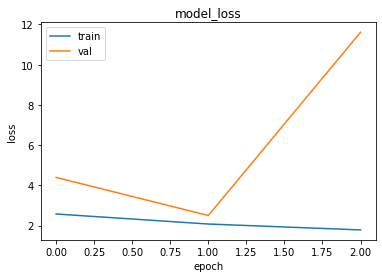

<Figure size 432x288 with 0 Axes>

In [128]:
plt.plot(train_sh.history['loss'])
plt.plot(train_sh.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()
plt.savefig("loss_plot.PNG")

In [129]:
!pwd

/home/ragou/repo/github/RAPMC/notebook


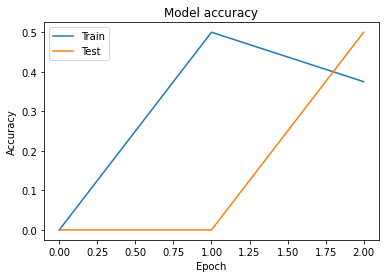

In [131]:
plt.plot(train_sh.history['accuracy'])
plt.plot(train_sh.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("acc_plot.jpg")